In [1]:
import numpy as np
import pandas as pd
import scipy

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.metrics import confusion_matrix, classification_report
from statsmodels.stats.diagnostic import het_breuschpagan

from IPython.display import display_html
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

import warnings

%matplotlib inline

In [2]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import LeaveOneOutEncoder

In [4]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")


def eval_preds(y_true, y_pred):
    error = y_true - y_pred

    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse:.2f}")
    print(f"mae {mae:.2f}")
    print(f"mape {mape:.2f}")

    line_pts = [y_true.min(), y_true.max()]
    plt.scatter(y_true, y_pred)
    plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Fit")
    plt.show()

In [5]:
def display_side_by_side(*args):
    html_str = ""
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace("table", 'table style="display:inline"'), raw=True)


def top_corrs(df, column, n=20):
    corr_df = df.corr()[[column]]
    corr_df.columns = ["corr"]
    corr_df["abs_corr"] = corr_df.abs()

    top_n_num = corr_df.sort_values("abs_corr", ascending=False).head(20)
    return top_n_num


def plot_top_corrs(df, column, n=10):
    top_corrs_df = top_corrs(df, column, n)
    top_feats = top_corrs_df.index
    top_corr = df[top_feats]
    top_corr_tall = pd.melt(top_corr, column)

    fg = sns.FacetGrid(top_corr_tall, col="variable", col_wrap=5, sharex=False)
    fg.map(sns.scatterplot, "value", column)
    plt.show()
    

In [6]:
df = pd.read_csv(r'noshowappointments-Copy1.csv')

In [7]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.990000e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.590000e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.260000e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.680000e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.840000e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [8]:
#dropping Appointment ID as it's irrelevant
df = df.drop(columns = 'AppointmentID')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   Gender          110527 non-null  object 
 2   ScheduledDay    110527 non-null  object 
 3   AppointmentDay  110527 non-null  object 
 4   Age             110527 non-null  int64  
 5   Neighbourhood   110527 non-null  object 
 6   Scholarship     110527 non-null  int64  
 7   Hipertension    110527 non-null  int64  
 8   Diabetes        110527 non-null  int64  
 9   Alcoholism      110527 non-null  int64  
 10  Handcap         110527 non-null  int64  
 11  SMS_received    110527 non-null  int64  
 12  No-show         110527 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usage: 11.0+ MB


In [10]:
# 81 unique neighborhoods
df.Neighbourhood.nunique()

81

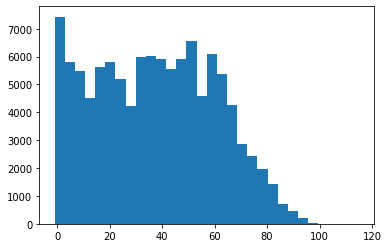

In [11]:
plt.hist(df['Age'], bins=30)
plt.show()

Will remove zero and negative ages since I want to log transform the target, Age. Will also remove those 95 and over as outliers since both linear regression and kNN are both sensitive to outliers. There is enough data to remove them. 

In [12]:
# there are 3540 rows with 0 ages and one with a negative age. 
df = df[df['Age'] > 0]

In [13]:
df = df[df['Age'] < 96]
df.shape

(106941, 13)

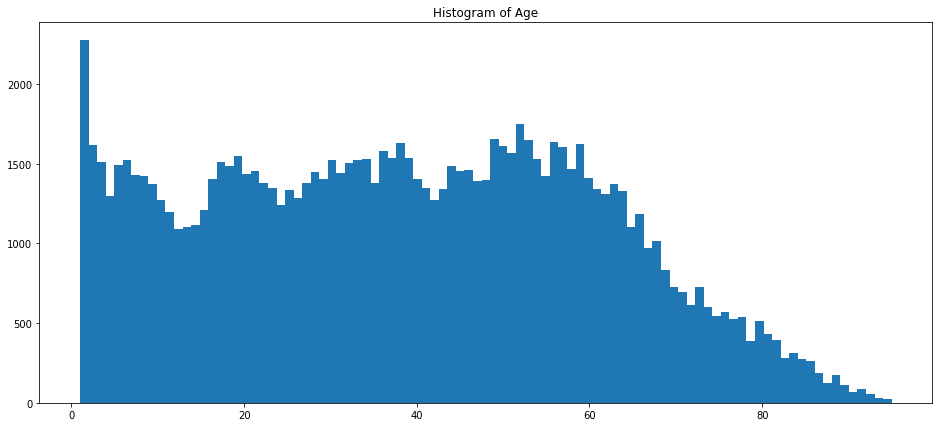

In [14]:
# distribution of target after removing columns
plt.figure(figsize=(16,7))
plt.hist(df['Age'],bins=95)
plt.title('Histogram of Age')
plt.show()

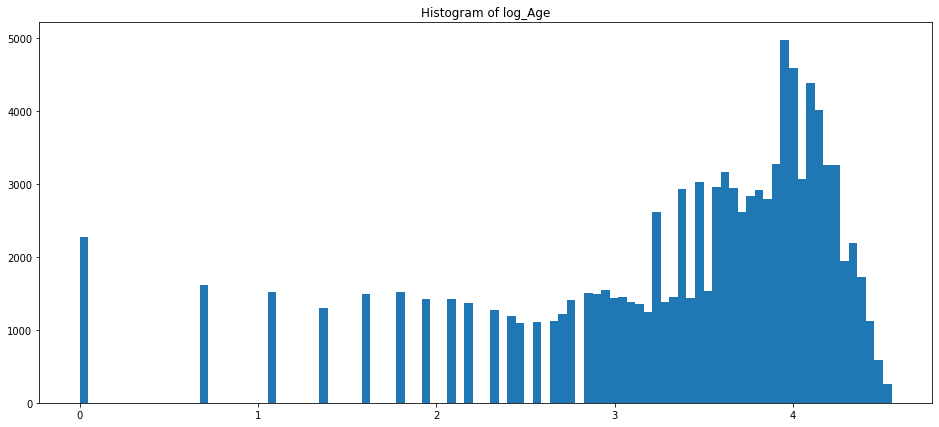

In [15]:
# distribution of target variable transformed

plt.figure(figsize=(16,7))
plt.hist(np.log(df['Age']),bins=95)
plt.title('Histogram of log_Age')
plt.show()

In [16]:
# converting to datetime
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

In [17]:
# getting weekday info in boht ScheduleDay and Appointment Day
df["sch_weekday_num"] = df["ScheduledDay"].dt.weekday
df["sch_weekday_name"] = df["ScheduledDay"].dt.day_name()

In [18]:
df["appt_weekday_num"] = df["AppointmentDay"].dt.weekday
df["appt_weekday_name"] = df["AppointmentDay"].dt.day_name()

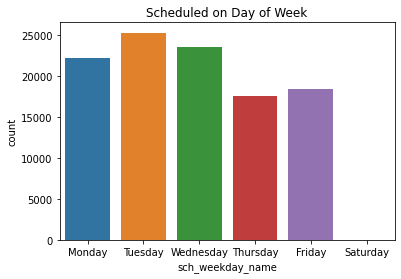

In [19]:
# Tuesday is the busiest day for making appointments

sns.countplot(x=df['sch_weekday_name'], order=['Monday','Tuesday', 'Wednesday','Thursday','Friday','Saturday'])
plt.title('Scheduled on Day of Week')
plt.show()

In [20]:
df.sch_weekday_num.value_counts()

1    25272
2    23534
0    22240
4    18362
3    17511
5       22
Name: sch_weekday_num, dtype: int64

In [21]:
df.appt_weekday_num.value_counts()

2    25081
1    24822
0    21895
4    18453
3    16651
5       39
Name: appt_weekday_num, dtype: int64

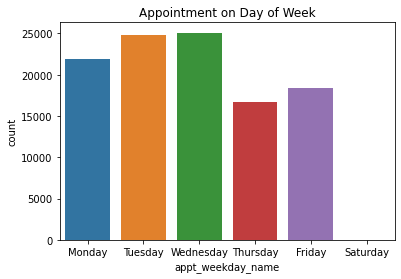

In [22]:
# Wednesday has the most appointments followed by Tuesday

sns.countplot(x=df['appt_weekday_name'], order=['Monday','Tuesday', 'Wednesday','Thursday','Friday','Saturday'])
plt.title('Appointment on Day of Week')
plt.show()

In [23]:
df['is_male'] = df.Gender.transform(lambda x: int(x =='M'))
df = df.drop(columns="Gender")

In [24]:
df['no_show'] = df['No-show'].transform(lambda x: int(x =='Yes'))
df = df.drop(columns='No-show')

In [25]:
df['has_diabetes_and_hyper'] = df['Hipertension'] * df['Diabetes']
df = df.drop(columns=['Hipertension','Diabetes'])

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106941 entries, 0 to 110526
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   PatientId               106941 non-null  float64            
 1   ScheduledDay            106941 non-null  datetime64[ns, UTC]
 2   AppointmentDay          106941 non-null  datetime64[ns, UTC]
 3   Age                     106941 non-null  int64              
 4   Neighbourhood           106941 non-null  object             
 5   Scholarship             106941 non-null  int64              
 6   Alcoholism              106941 non-null  int64              
 7   Handcap                 106941 non-null  int64              
 8   SMS_received            106941 non-null  int64              
 9   sch_weekday_num         106941 non-null  int64              
 10  sch_weekday_name        106941 non-null  object             
 11  appt_weekday_num        10

In [27]:
categorical = df.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

Neighbourhood
81
sch_weekday_name
6
appt_weekday_name
6


In [28]:
# only weak or no correlations between numerical features

log_df = df.copy()
log_df["log_age"] = np.log(log_df["Age"])
log_df = log_df.drop(columns=["Age"])

top_n_corrs = top_corrs(df, "Age")
log_top_n_corrs = top_corrs(log_df, "log_age")

display_side_by_side(top_n_corrs, log_top_n_corrs)

,corr,abs_corr
Age,1.000000,1.000000
has_diabetes_and_hyper,0.282885,0.282885
Scholarship,-0.112491,0.112491
is_male,-0.093893,0.093893
Alcoholism,0.090746,0.090746
Handcap,0.072818,0.072818
no_show,-0.067037,0.067037
sch_weekday_num,0.007323,0.007323
SMS_received,0.005838,0.005838
PatientId,-0.003243,0.003243


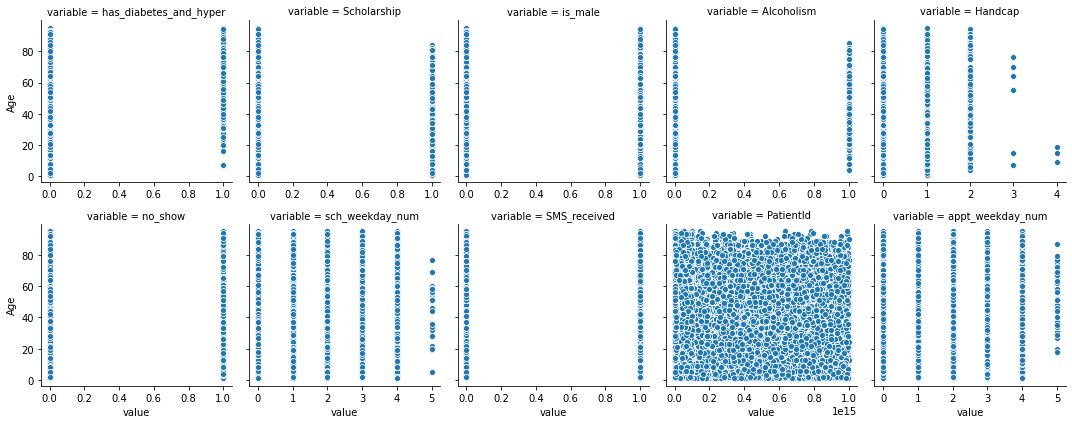

In [29]:
plot_top_corrs(df, "Age")

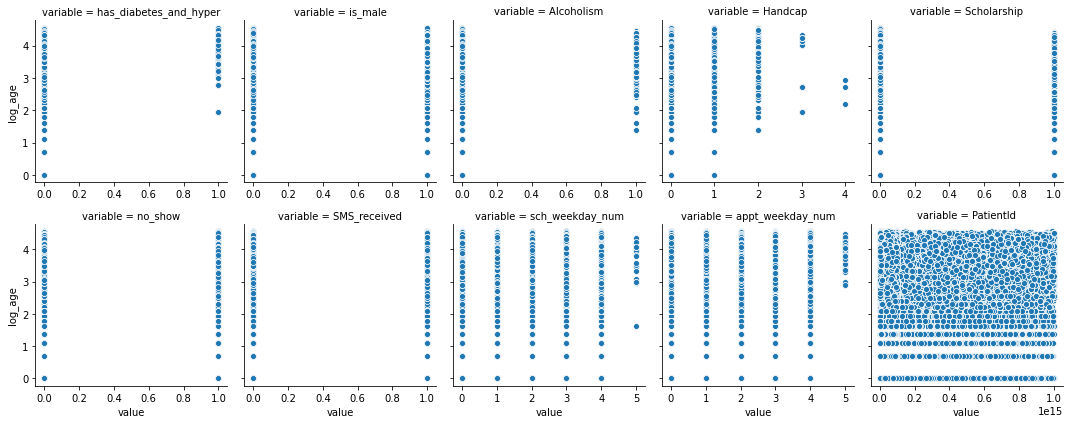

In [30]:
plot_top_corrs(log_df, "log_age")

In [31]:
crosstable = pd.crosstab(df["Age"], df["Neighbourhood"])
crosstable.head()

Neighbourhood,AEROPORTO,ANDORINHAS,ANTÔNIO HONÓRIO,ARIOVALDO FAVALESSA,BARRO VERMELHO,BELA VISTA,BENTO FERREIRA,BOA VISTA,BONFIM,CARATOÍRA,...,SANTOS REIS,SEGURANÇA DO LAR,SOLON BORGES,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,UNIVERSITÁRIO,VILA RUBIM
Age,,,,,,,,,,,,,,,,,,,,,
1,0,29,0,4,3,37,5,10,72,53,...,13,3,7,71,46,53,83,53,0,16
2,0,37,7,5,5,31,4,7,36,44,...,5,4,0,28,13,50,25,51,3,6
3,0,32,2,2,1,30,15,10,34,33,...,2,2,3,17,35,30,17,55,1,5
4,0,16,1,2,1,20,4,5,30,26,...,10,7,5,28,16,19,26,62,1,1
5,0,31,3,9,5,10,3,11,40,43,...,7,2,4,33,22,38,42,66,0,3


In [32]:
df.Age.value_counts(bins=10)

(0.905, 10.4]    15210
(48.0, 57.4]     14422
(38.6, 48.0]     14093
(19.8, 29.2]     13699
(29.2, 38.6]     13635
(57.4, 66.8]     12152
(10.4, 19.8]     11662
(66.8, 76.2]      7293
(76.2, 85.6]      3661
(85.6, 95.0]      1114
Name: Age, dtype: int64

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106941 entries, 0 to 110526
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   PatientId               106941 non-null  float64            
 1   ScheduledDay            106941 non-null  datetime64[ns, UTC]
 2   AppointmentDay          106941 non-null  datetime64[ns, UTC]
 3   Age                     106941 non-null  int64              
 4   Neighbourhood           106941 non-null  object             
 5   Scholarship             106941 non-null  int64              
 6   Alcoholism              106941 non-null  int64              
 7   Handcap                 106941 non-null  int64              
 8   SMS_received            106941 non-null  int64              
 9   sch_weekday_num         106941 non-null  int64              
 10  sch_weekday_name        106941 non-null  object             
 11  appt_weekday_num        10

## Model Prep

In [34]:
# getting error message after fitting ValueError: could not convert string to float: 'CARATOÍRA'

#cat_cols = ['Neighbourhood']

#drop_cats = ['JARDIM CAMBURI']

bin_cols = ['is_male','Scholarship', 'Alcoholism', 'has_diabetes_and_hyper']

num_cols = ['PatientId', 'Handcap']

In [35]:
X = df.drop(columns=["Age", 'sch_weekday_name', 'appt_weekday_name', 'ScheduledDay','Neighbourhood'
                     , 'AppointmentDay','SMS_received','no_show', 'sch_weekday_num', 'appt_weekday_num'])
y = df["Age"]

In [36]:
#X = log_df.drop(columns=["log_age",'sch_weekday_name', 'appt_weekday_name', 'ScheduledDay', 'AppointmentDay'])
#y = log_df["log_age"]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [38]:
preprocessing = ColumnTransformer([
    ("scaler", StandardScaler(), num_cols)
], remainder="passthrough")

In [39]:
pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("en", ElasticNet()),
])

## Linear Regression Model

In [40]:
grid = {"alpha": [0.0001, 0.001, 0.01, 0.1], "l1_ratio": [0.1, 0.5, 0.75, 1]}
elasticnet_cv = GridSearchCV(ElasticNet(), grid, verbose=1)
elasticnet_cv.fit(X_train, y_train)

print(f"selected alpha: {elasticnet_cv.best_estimator_.alpha}")
print(f"selected l1_ratio: {elasticnet_cv.best_estimator_.l1_ratio}")
elasticnet_cv.best_estimator_.coef_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11449807.363533417, tolerance: 2585.133141088232
  positive)
C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11424489.794614254, tolerance: 2584.496664140578
  positive)
C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11443828.743741982, tolerance: 2585.133141088232
  positive)
C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective 

selected alpha: 0.0001
selected l1_ratio: 0.75


array([-8.35868653e-17, -8.97682722e+00,  1.32166021e+01,  8.30951816e+00,
       -5.42170259e+00,  2.56054305e+01])

In [41]:
coef_df = pd.DataFrame()
coef_df["feat"] = X_train.columns
coef_df["coef"] = elasticnet_cv.best_estimator_.coef_
coef_df

,feat,coef
0,PatientId,-8.358687e-17
1,Scholarship,-8.976827e+00
2,Alcoholism,1.321660e+01
3,Handcap,8.309518e+00
4,is_male,-5.421703e+00
5,has_diabetes_and_hyper,2.560543e+01


In [54]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                      -6.506
Model:                            OLS   Adj. R-squared:                 -6.506
Method:                 Least Squares   F-statistic:                -5.561e+04
Date:                Sun, 03 Jan 2021   Prob (F-statistic):               1.00
Time:                        19:43:20   Log-Likelihood:            -3.5531e+05
No. Observations:               64164   AIC:                         7.106e+05
Df Residuals:                   64162   BIC:                         7.106e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     38

In [55]:
elasticnet_cv.score(X_train, y_train)

0.11477376191095623

In [56]:
elasticnet_cv.score(X_test, y_test)

0.11301298372373558

In [57]:
y_pred = elasticnet_cv.predict(X_test)

In [58]:
# null hypothesis: data is homoscedastic
# alternative hypothesis: data is heteroscedastic
true_residuals = model.resid
_, p, _, _ = het_breuschpagan(true_residuals, X_train_const)
p

0.0

In [60]:
pred_df = X_test.copy()
pred_df["actual"] = (y_test)
pred_df = pred_df.reset_index()

pred_df["predicted"] = (elasticnet_cv.predict(X_test))

pred_df["residual"] = pred_df["predicted"] - pred_df["actual"]
pred_df["abs_residual"] = pred_df["residual"].abs()
pred_df["perc_residual"] = pred_df["abs_residual"] / pred_df["actual"]

print(f'Mean Absolute Error: {pred_df["abs_residual"].mean():.2f}')
print(f'Mean Absolute Percent Error: {pred_df["perc_residual"].mean() * 100:.2f}%')


#pred_df = X_test.copy()
#pred_df["actual"] = np.exp(y_test)
#pred_df = pred_df.reset_index()

#pred_df["predicted"] = np.esp(elasticnet_cv.predict(X_test))

#pred_df["residual"] = pred_df["predicted"] - pred_df["actual"]
#pred_df["abs_residual"] = pred_df["residual"].abs()
#pred_df["perc_residual"] = pred_df["abs_residual"] / pred_df["actual"]

#print(f'Mean Absolute Error: {pred_df["abs_residual"].mean():.2f}')
#print(f'Mean Absolute Percent Error: {pred_df["perc_residual"].mean() * 100:.2f}%')

Mean Absolute Error: 17.68
Mean Absolute Percent Error: 194.14%


## kNN Model

In [48]:
# fmt: off
preprocessing = ColumnTransformer([
    ('scale', StandardScaler(), num_cols)
])
# fmt: on

In [49]:
# fmt: off

pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("knn", KNeighborsRegressor()),
])

In [50]:
param_grid = {"knn__n_neighbors": [25, 50, 75]}

knn_cv = GridSearchCV(pipeline, param_grid)
knn_cv.fit(X_train, y_train)

print(f"train score: {knn_cv.score(X_train, y_train)}")
print(f"test score: {knn_cv.score(X_test, y_test)}")

train score: 0.05458412219915454
test score: 0.012023442425493802


In [51]:
knn_cv.best_params_

{'knn__n_neighbors': 50}

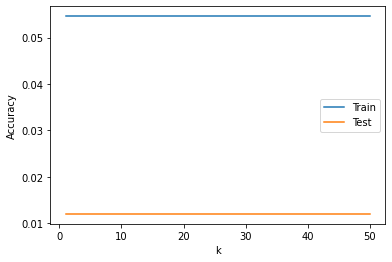

In [52]:
ks = [1, 5, 10, 25, 50]
train_scores = []
test_scores = []

for k in ks:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)

    train_score = knn_cv.score(X_train, y_train)
    test_score = knn_cv.score(X_test, y_test)

    train_scores.append(train_score)
    test_scores.append(test_score)

plt.plot(ks, train_scores, label="Train")
plt.plot(ks, test_scores, label="Test")
plt.xlabel("k")  # label x axis
plt.ylabel("Accuracy")  # label y axis
plt.legend()  # Display a legend
plt.show()

In [53]:
df.shape

(106941, 16)

After doing both a linear regression using Elastic Net and a kNN CV it appears that Elastic Net did slight better although both models peformed poorly in predicting a patient's age from the data. The data was weakly correlated and the only variable that may be somewhat of a predictor was the patient's neighborhood but with 81 different neighborhoods and 106,941 observations with ages ranging from 1 to 95 it will be difficult to predict using these models. I think a decision tree may help find out if neighborhood is actually important or not. 

With these two test, we can see that OLS returned an R2 of -6.558 while the elastic net returned a score of R2 11.3 on the train and 11.7 on the test data. It appears that elastic net may have been slightly better than OLS but again, both linear regression and kNN performed poorly. 